# Binary Model - Random Forest

Based on the target values and using the test_trial method, we have set a threshold of 10.0 to convert the continuous target into a binary target. Subsequently, we employ the Random Forest Classification algorithm on the input dataset with the binary target. We evaluate the model performance using the Confusion Matrix and Classification Report.


In [5]:
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import imblearn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
)
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from utils import get_training_dataset

In [7]:
# Read csv file and import to df
df = get_training_dataset()
df.head()

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,strong_roof_strong_wall,...,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged,percent_houses_damaged_5years
0,DURIAN,2006,101,0.0,303.180555,0.122917,0.085417,31.000000,NaN,22.580645,...,2.699781,5.762712,3445.709753,1,0.0,0.00,1.00,0.000000,0.0,0.0
1,DURIAN,2006,4475,0.0,638.027502,0.091667,0.027083,3.301020,-0.527000,2.639401,...,4.585088,12.799127,8602.645832,1,0.0,0.00,1.00,0.000000,0.0,0.0
2,DURIAN,2006,4639,0.0,603.631997,0.535417,0.146354,12.103741,-0.283000,2.639401,...,1.527495,8.833333,5084.012925,1,0.0,0.01,0.99,197.339034,0.0,0.0
3,DURIAN,2006,4640,0.0,614.675270,0.356250,0.101562,645.899660,-0.358889,2.639401,...,11.677657,17.530431,55607.865950,1,0.0,0.31,0.69,4970.477311,0.0,0.0
4,DURIAN,2006,4641,0.0,625.720905,0.202083,0.057812,1071.731293,-0.462800,2.639401,...,17.074011,31.931338,35529.342507,1,0.0,0.77,0.23,12408.594656,0.0,0.0


In [8]:
# Fill NaNs with average estimated value of 'rwi'
df["rwi"].fillna(df["rwi"].mean(), inplace=True)

# Set any values >100% to 100%,
for i in range(len(df)):
    if df.loc[i, "percent_houses_damaged"] > 100:
        df.at[i, "percent_houses_damaged"] = float(100)

In [9]:
# define a threshold to separate target into damaged and not_damaged
thres = 10.0

for i in range(len(df)):
    if df.loc[i, "percent_houses_damaged"] >= thres:
        df.at[i, "binary_damage"] = 1
    else:
        df.at[i, "binary_damage"] = 0

df["binary_damage"] = df["binary_damage"].astype("int")

# Remove previous target 'percent_buildings_damaged' from the dataframe
df = df.drop(["percent_houses_damaged"], axis=1)
df

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,strong_roof_strong_wall,...,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged_5years,binary_damage
0,DURIAN,2006,101,0.0,303.180555,0.122917,0.085417,31.000000,-0.213039,22.580645,...,2.699781,5.762712,3445.709753,1,0.00,0.000000,1.000000,0.000000,0.000000,0
1,DURIAN,2006,4475,0.0,638.027502,0.091667,0.027083,3.301020,-0.527000,2.639401,...,4.585088,12.799127,8602.645832,1,0.00,0.000000,1.000000,0.000000,0.000000,0
2,DURIAN,2006,4639,0.0,603.631997,0.535417,0.146354,12.103741,-0.283000,2.639401,...,1.527495,8.833333,5084.012925,1,0.00,0.010000,0.990000,197.339034,0.000000,0
3,DURIAN,2006,4640,0.0,614.675270,0.356250,0.101562,645.899660,-0.358889,2.639401,...,11.677657,17.530431,55607.865950,1,0.00,0.310000,0.690000,4970.477311,0.000000,0
4,DURIAN,2006,4641,0.0,625.720905,0.202083,0.057812,1071.731293,-0.462800,2.639401,...,17.074011,31.931338,35529.342507,1,0.00,0.770000,0.230000,12408.594656,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141253,MOLAVE,2020,20677,0.0,644.575831,2.543750,0.778646,4449.357133,0.508167,44.762048,...,18.012771,36.304688,21559.003490,1,0.08,0.080000,0.840000,17619.701390,0.000000,0
141254,MOLAVE,2020,20678,0.0,655.685233,2.558333,0.861458,1521.435795,-0.174100,44.762048,...,13.163042,65.687266,12591.742022,1,0.00,0.420000,0.580000,5623.069564,0.000000,0
141255,MOLAVE,2020,20679,0.0,666.794635,2.975000,0.949479,930.647069,-0.244286,25.078318,...,10.901755,37.414996,19740.596834,1,0.00,0.109091,0.890909,5912.671746,0.015207,0
141256,MOLAVE,2020,20680,0.0,677.904037,2.889583,1.083333,1800.666044,0.038000,16.796996,...,17.917650,105.812452,26363.303778,1,0.03,0.250000,0.720000,11254.164413,0.020806,0


In [10]:
# Remove zeros from wind_speed
df = df[(df[["wind_speed"]] != 0).any(axis=1)]
df = df.drop(columns=["grid_point_id", "typhoon_year"])
df.head()

,typhoon_name,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,strong_roof_strong_wall,strong_roof_light_wall,strong_roof_salvage_wall,...,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged_5years,binary_damage
138,DURIAN,12.460039,275.018491,0.670833,0.313021,0.479848,-0.213039,31.336503,29.117802,0.042261,...,34.629550,42.218750,5303.659490,1,0.00,0.00,1.00,0.000000,0.0,0
139,DURIAN,11.428974,297.027578,0.929167,0.343229,55.649739,0.206000,23.447758,23.591571,0.037516,...,25.475388,72.283154,61015.543599,1,0.00,0.14,0.86,276.871504,0.0,0
148,DURIAN,13.077471,262.598363,0.716667,0.424479,8.157414,-0.636000,31.336503,29.117802,0.042261,...,54.353996,102.215198,66707.438070,1,0.00,0.11,0.89,448.539453,0.0,0
149,DURIAN,12.511864,273.639330,0.568750,0.336979,88.292015,-0.227500,31.336503,29.117802,0.042261,...,31.814048,58.988877,53841.050168,1,0.00,0.12,0.88,2101.708435,0.0,0
150,DURIAN,11.977511,284.680297,0.589583,0.290625,962.766739,-0.299667,23.546053,23.660429,0.037576,...,25.976413,111.386527,87378.257957,1,0.07,0.46,0.47,11632.726327,0.0,0


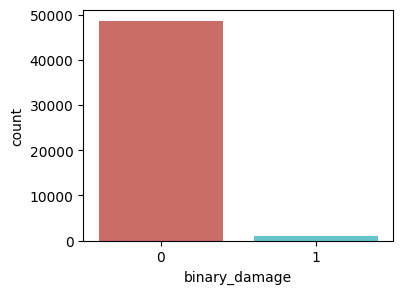

In [11]:
plt.figure(figsize=(4, 3))
sns.countplot(x="binary_damage", data=df, palette="hls")
plt.show()

array([[<AxesSubplot: title={'center': 'binary_damage'}>]], dtype=object)

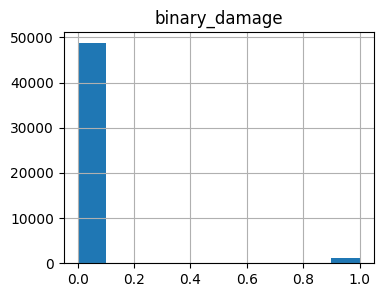

In [12]:
# Show histogram of damage
df.hist(column="binary_damage", figsize=(4, 3))

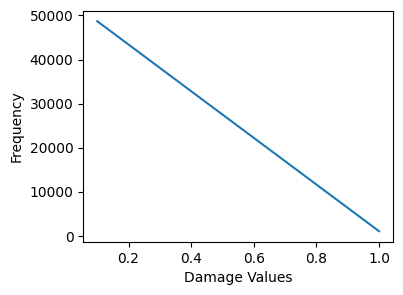

In [13]:
# Hist plot after data stratification
bins2 = [0, 0.1, 1]
samples_per_bin2, binsP2 = np.histogram(df["binary_damage"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [14]:
# Check the bins' intervalls (first bin means all zeros, second bin means 0 < values <= 1)
df["binary_damage"].value_counts(bins=binsP2)

(-0.001, 0.1]    48685
(0.1, 1.0]        1069
Name: binary_damage, dtype: int64

In [15]:
bin_index2 = np.digitize(df["binary_damage"], bins=binsP2)

In [16]:
y_input_strat = bin_index2

In [17]:
features = [
    "wind_speed",
    "track_distance",
    "total_houses",
    "rainfall_max_6h",
    "rainfall_max_24h",
    "rwi",
    "mean_slope",
    "std_slope",
    "mean_tri",
    "std_tri",
    "mean_elev",
    "coast_length",
    "with_coast",
    "urban",
    "rural",
    "water",
    "total_pop",
    "percent_houses_damaged_5years",
]

# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["binary_damage"]

Index(['wind_speed', 'track_distance', 'total_houses', 'rainfall_max_6h',
       'rainfall_max_24h', 'rwi', 'mean_slope', 'std_slope', 'mean_tri',
       'std_tri', 'mean_elev', 'coast_length', 'with_coast', 'urban', 'rural',
       'water', 'total_pop', 'percent_houses_damaged_5years'],
      dtype='object')

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, df["binary_damage"], stratify=y_input_strat, test_size=0.2
)

In [19]:
# Check train data before resampling
print(Counter(y_train))

Counter({0: 38948, 1: 855})


In [20]:
# Ask the user whether to perform oversampling or undersampling
sampling_type = int(
    input(
        "Enter 1 for oversampling, 2 for undersampling or 3 for combination of both: "
    )
)

In [21]:
if sampling_type == 1:
    # Define oversampling strategy
    over = RandomOverSampler(sampling_strategy=0.1)
    # Fit and apply the transform
    X_train, y_train = over.fit_resample(X_train, y_train)

elif sampling_type == 2:
    under = RandomUnderSampler(sampling_strategy=0.7)
    X_train, y_train = under.fit_resample(X_train, y_train)

elif sampling_type == 3:
    over = RandomOverSampler(sampling_strategy=0.1)
    X_train, y_train = over.fit_resample(X_train, y_train)

    under = RandomUnderSampler(sampling_strategy=0.7)
    X_train, y_train = under.fit_resample(X_train, y_train)


else:
    print("Invalid input. Please enter 1, 2 or 3.")

In [22]:
# Summarize class distribution of oversampling
print(Counter(y_train))

Counter({0: 1221, 1: 855})


In [23]:
# Define a list to keep f1_score of each n_estimator
f1_lst = []
n_estimator_lst = []

In [24]:
# Random Forest regression model
model_clf = RandomForestClassifier()
model_clf.fit(X_train, y_train)

# Make predictions for the test set
y_pred = model_clf.predict(X_test)

In [25]:
# View confusion matrix for test data and predictions
matrix = confusion_matrix(y_test, y_pred)
matrix

array([[9085,  652],
       [  13,  201]], dtype=int64)

In [26]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      9737
           1       0.24      0.94      0.38       214

    accuracy                           0.93      9951
   macro avg       0.62      0.94      0.67      9951
weighted avg       0.98      0.93      0.95      9951



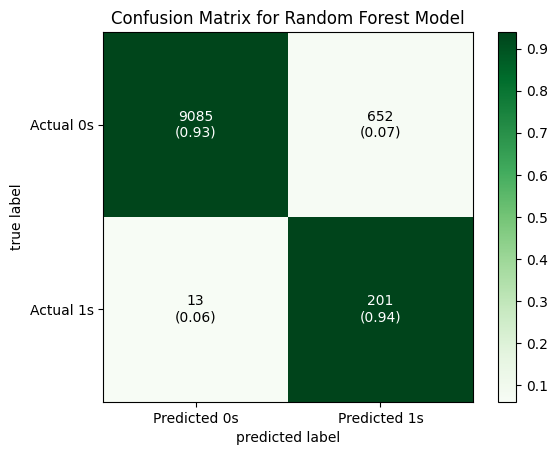

In [27]:
# Binary absolute and relative with colorbar
fig, ax = plot_confusion_matrix(
    conf_mat=matrix,
    show_absolute=True,
    show_normed=True,
    colorbar=True,
    cmap=plt.cm.Greens,
)

ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=("Predicted 0s", "Predicted 1s"))
ax.yaxis.set(ticks=(0, 1), ticklabels=("Actual 0s", "Actual 1s"))
plt.title("Confusion Matrix for Random Forest Model")
plt.show()

## Feature Importance

Text(0.5, 1.0, 'Random Forest')

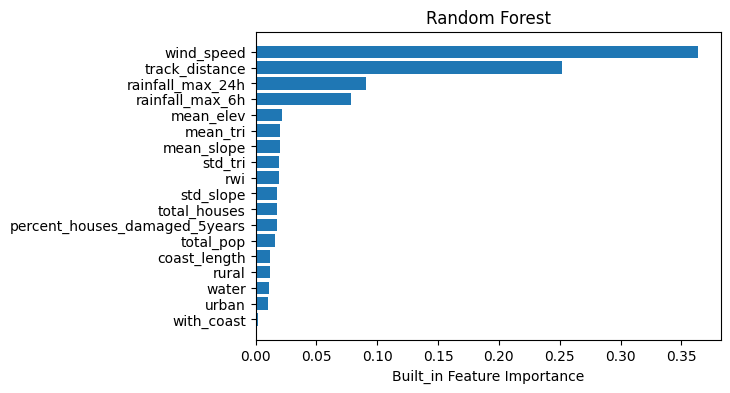

In [28]:
# Random Forest Built-in Feature Importance

plt.rcParams.update({"figure.figsize": (6.0, 4.0)})
plt.rcParams.update({"font.size": 10})

model_clf.feature_importances_

sorted_idx = model_clf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model_clf.feature_importances_[sorted_idx])
plt.xlabel("Built_in Feature Importance")
plt.title("Random Forest")